In [1]:
import pandas as pd
import numpy as np

In [2]:
bca = pd.read_csv("bca_preprocessed_data.csv", delimiter=',')
bca.head(5)

,content,score,sentiment
0,mohon donk kembalikan tanda biru hitam saat li...,1,0
1,kenapa sekarang untuk transfer ke blu bca ada ...,2,0
2,oke terimakasih,5,2
3,tolong pihak developer untuk update hp saya ga...,5,2
4,ok,5,2


In [3]:
bca.isnull().sum()

content      61
score         0
sentiment     0
dtype: int64

In [4]:
bca = bca.dropna()

In [5]:
bca.isnull().sum()

content      0
score        0
sentiment    0
dtype: int64

In [6]:
bca.shape

(13939, 3)

#### Creating Topic

In [7]:
import gensim
import gensim.corpora as corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import nltk

#ensure NLTK downloaded
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Darren\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Darren\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
bca = bca.dropna(subset=["content"])

#### Preprocess words

In [17]:
stop_words_indo = set(stopwords.words("indonesian"))
stop_words_en = set(stopwords.words("english"))
custom_stopwords = {"nya", "yg", "gak", "ga", "sih", "dong", "deh", "nih", "aja", "bgt","saya", "dan"}

stop_words = stop_words_indo.union(stop_words_en, custom_stopwords)

def preprocess_text(text):
    text = text.lower() #convert to lowercase
    text = re.sub(r'\d+', '',text) #remove numbers
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'(.)\1+', r'\1\1', text) #limit repeating characters
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

bca["processedwords"] = bca["content"].apply(preprocess_text)

dictionary = corpora.Dictionary(bca["processedwords"])
corpus = [dictionary.doc2bow(text)for text in bca["processedwords"]]

len(dictionary), corpus[:5]


(12688,
 [[(0, 2), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
  [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1)],
  [(14, 1), (15, 1)],
  [(16, 1), (17, 1), (18, 1), (19, 1), (20, 1)],
  [(21, 1)]])

#### Applying LDA(Latent Dirichlet Allocation)

In [18]:
lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=5,
                                   random_state=42,
                                   passes=10)

topics = lda_model.print_topics(num_words=10)
topics

[(0,
  '0.034*"verifikasi" + 0.025*"aplikasi" + 0.020*"gagal" + 0.017*"udah" + 0.014*"hp" + 0.014*"ulang" + 0.013*"update" + 0.012*"wajah" + 0.012*"bca" + 0.011*"ribet"'),
 (1,
  '0.070*"bca" + 0.032*"mobile" + 0.027*"aplikasi" + 0.018*"buka" + 0.017*"update" + 0.015*"tolong" + 0.014*"ya" + 0.010*"error" + 0.010*"bank" + 0.009*"mohon"'),
 (2,
  '0.040*"good" + 0.032*"bagus" + 0.018*"membantu" + 0.018*"ok" + 0.016*"mudah" + 0.016*"transaksi" + 0.015*"fitur" + 0.013*"transfer" + 0.012*"inbox" + 0.011*"menu"'),
 (3,
  '0.026*"saldo" + 0.017*"flazz" + 0.014*"bank" + 0.014*"merah" + 0.014*"transaksi" + 0.013*"top" + 0.012*"cek" + 0.009*"lampu" + 0.008*"bca" + 0.008*"transfer"'),
 (4,
  '0.052*"update" + 0.047*"force" + 0.047*"close" + 0.042*"app" + 0.016*"versi" + 0.015*"dibuka" + 0.012*"terbaru" + 0.011*"apps" + 0.011*"crash" + 0.010*"aplikasi"')]

#### Visualize Topic Distribution

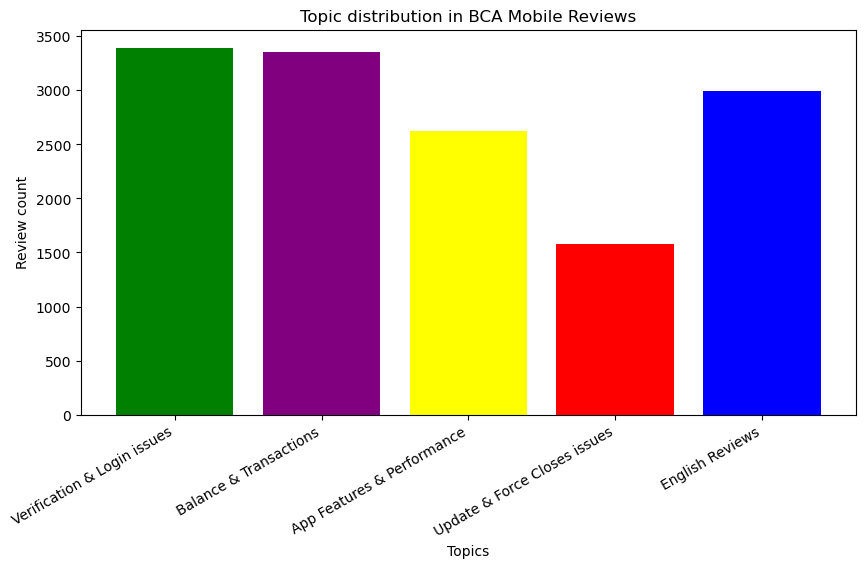

In [19]:
import matplotlib.pyplot as plt

topic_counts = lda_model.get_document_topics(corpus, minimum_probability=0)
topic_distributions = [0] * 5

for doc in topic_counts:
    main_topic = max(doc, key=lambda x: x[1])[0] #get most relevant topic
    topic_distributions[main_topic] += 1

topic_labels =[
    "Verification & Login issues",
    "Balance & Transactions",
    "App Features & Performance",
    "Update & Force Closes issues",
    "English Reviews"
]

#plot bar chart
plt.figure(figsize=(10,5))
plt.bar(topic_labels, topic_distributions, color=["green","purple","yellow","red","blue"])
plt.title("Topic distribution in BCA Mobile Reviews")
plt.xlabel("Topics")
plt.ylabel("Review count")
plt.xticks(rotation=30, ha="right") #make xlabel rotate to not overlap
plt.show()

#### Visualize Sentiment Distribution per topic 2

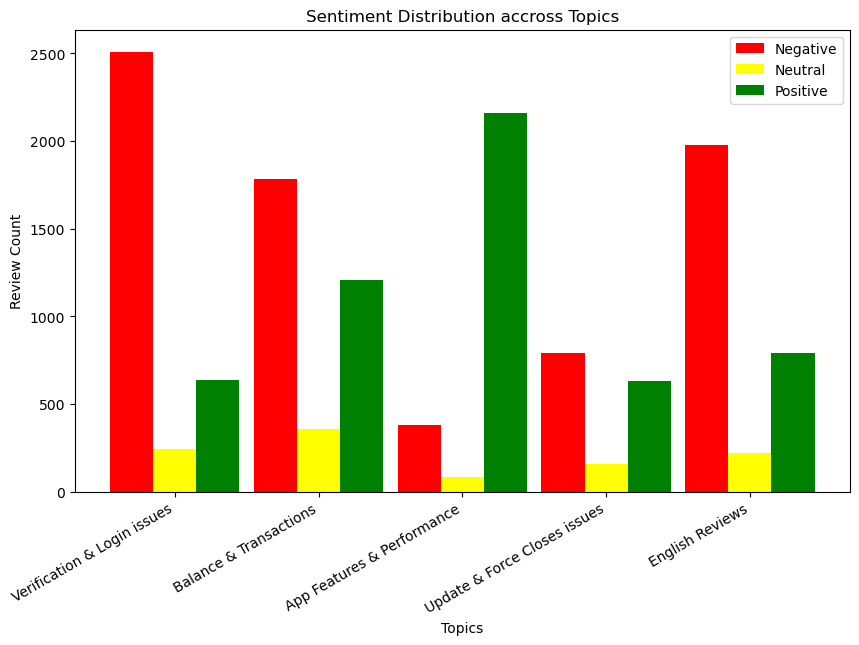

In [20]:
sentiment_per_topic = np.zeros((5,3))

for i, doc in enumerate(topic_counts):
    if i < len(bca):
        main_topic = max(doc, key=lambda x: x[1])[0]
        sentiment = int(bca.iloc[i]["sentiment"])
        sentiment_per_topic[main_topic][sentiment] +=1

#plot sentiment breakdown per topic

sentiment_labels = ["Negative","Neutral","Positive"]
colors = ["red","yellow","green"]


fig, ax = plt.subplots(figsize=(10,6))
bar_width = 0.3

for i in range(3):
    ax.bar(
        np.arange(5) + i * bar_width,  # Added a comma here
        sentiment_per_topic[:, i],
        bar_width,
        label=sentiment_labels[i],
        color=colors[i]
    )

ax.set_xlabel("Topics")
ax.set_ylabel("Review Count")
ax.set_title("Sentiment Distribution accross Topics")
ax.set_xticks(np.arange(5)+ bar_width)
ax.set_xticklabels(topic_labels, rotation=30,ha="right")
ax.legend()

plt.show()

#### Visualize through WordCloud Positive, Neutral and Negative

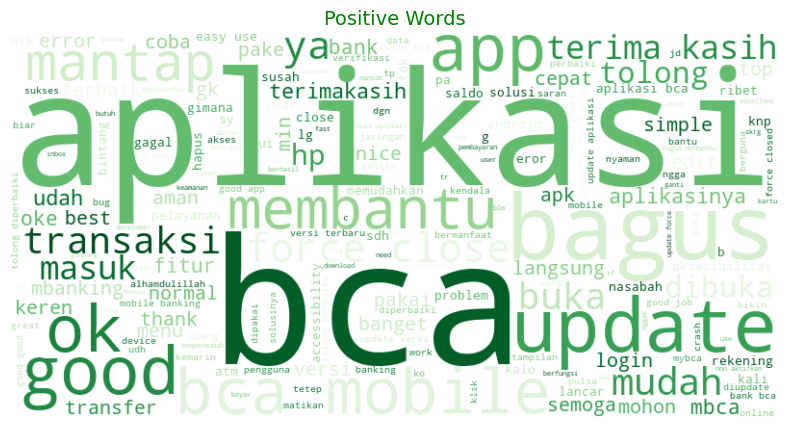

In [27]:
from wordcloud import WordCloud

Positive_text = " ".join(bca[bca["sentiment"]== 2]["processedwords"].dropna().apply(lambda x:" ".join(x)))

wordcloud_positives = WordCloud(width=800, height=400, background_color="white", colormap="Greens").generate(Positive_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_positives, interpolation="bilinear")
plt.title("Positive Words", fontsize=14, color="green")
plt.axis("off")
plt.show()

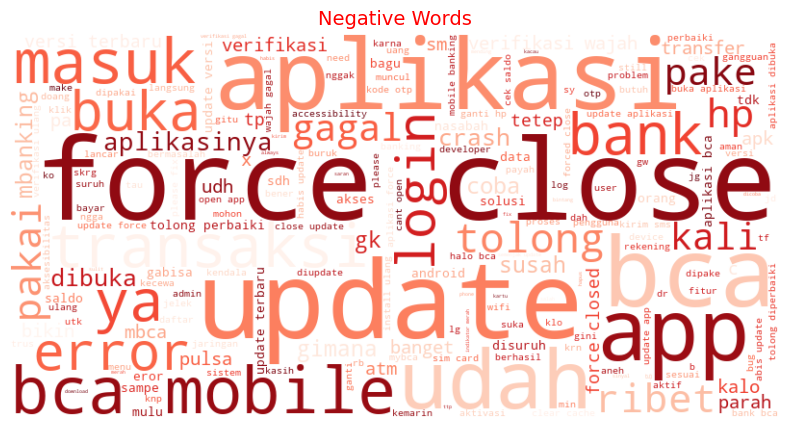

In [30]:
from wordcloud import WordCloud

Negative_text = " ".join(bca[bca["sentiment"]== 0]["processedwords"].dropna().apply(lambda x:" ".join(x)))

wordcloud_negatives = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(Negative_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_negatives, interpolation="bilinear")
plt.title("Negative Words", fontsize=14, color="red")
plt.axis("off")
plt.show()

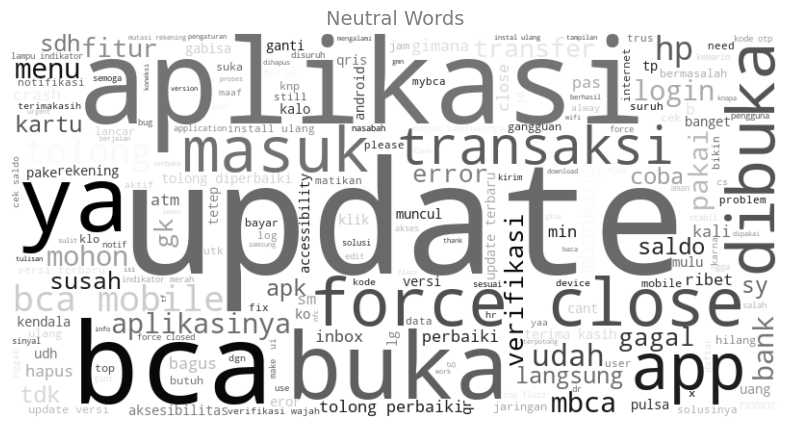

In [31]:
from wordcloud import WordCloud

Neutral_text = " ".join(bca[bca["sentiment"]== 1]["processedwords"].dropna().apply(lambda x:" ".join(x)))

wordcloud_neutrals = WordCloud(width=800, height=400, background_color="white", colormap="gray").generate(Neutral_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neutrals, interpolation="bilinear")
plt.title("Neutral Words", fontsize=14, color="gray")
plt.axis("off")
plt.show()

#### More Visualization 😁 3

<function matplotlib.pyplot.show(close=None, block=None)>

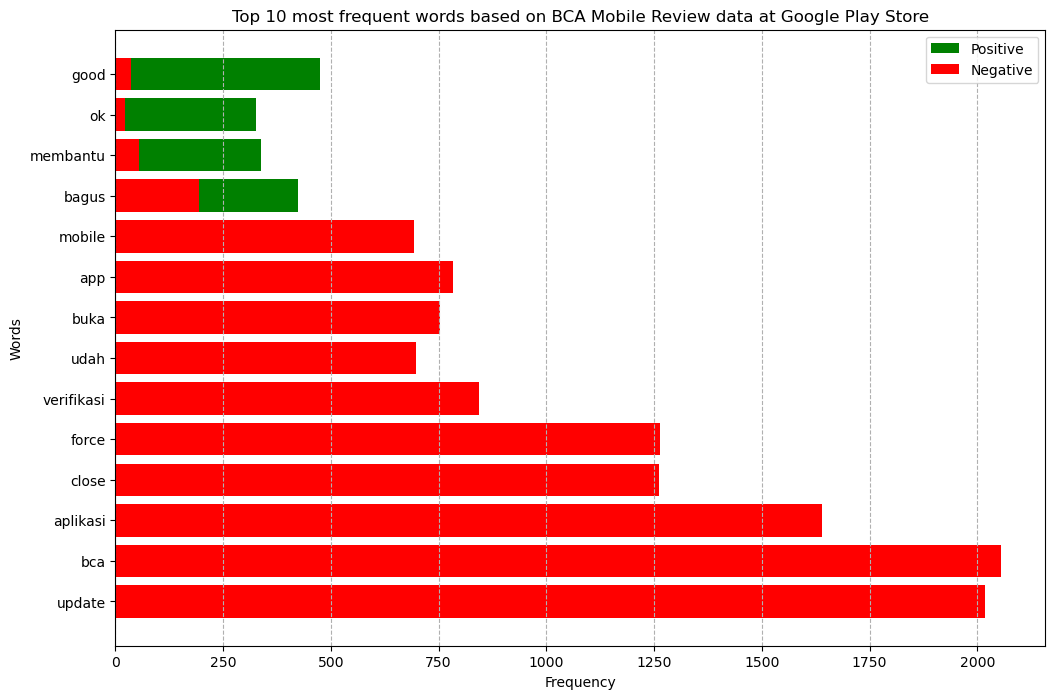

In [32]:
from collections import Counter

# calculate word frequencies for each sentiment
positive_words = bca[bca["sentiment"] == 2]['processedwords']
negative_words = bca[bca["sentiment"] == 0]['processedwords']
neutral_words = bca[bca["sentiment"] == 1]['processedwords']

positive_frequen = Counter([word for words in positive_words for word in words])
negative_frequen = Counter([word for words in negative_words for word in words])
neutral_words_frequen = Counter([word for words in neutral_words  for word in words])

# Get top 10 words from each sentiment

top_n = 10
top_positive = [word for word, _ in positive_frequen.most_common(top_n)]
top_negative = [word for word, _ in negative_frequen.most_common(top_n)]

#combine words and create DataFrame
combined_words = list(set(top_positive+top_negative))
bca_combined = pd.DataFrame({'word':combined_words})
bca_combined['positive'] = bca_combined['word'].apply(lambda x: positive_frequen.get(x,0 ))
bca_combined['negative'] = bca_combined['word'].apply(lambda x: negative_frequen.get(x,0))

# Sort
bca_combined['diff'] = bca_combined['positive'] - bca_combined['negative']
bca_sorted = bca_combined.sort_values('diff', ascending=True)

#Plot the visualization
plt.figure(figsize=(12,8))
plt.barh(bca_sorted['word'], bca_sorted['positive'], color='green', label='Positive')
plt.barh(bca_sorted['word'], bca_sorted['negative'], color='red', label='Negative')
plt.xlabel('Frequency')
plt.ylabel("Words")
plt.title('Top 10 most frequent words based on BCA Mobile Review data at Google Play Store')
plt.legend()
plt.grid(axis='x', linestyle='--')
plt.show